---
title: Climatological Average using GeoCAT comp 
author: Harsha R. Hampapura
date: 2026-02-11
---

## Access CESM2 data from GDEX and compute climatology average

In [1]:
# Imports
import geocat.comp as gc
import intake
import numpy as np
import pandas as pd
import xarray as xr
import re
import aiohttp
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import os

/glade/u/home/harshah/.conda/envs/osdf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import fsspec.implementations.http as fshttp
# from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
year0  = '1991'
year1  = '2020'
year0_str = str(year0)
year1_str = str(year1)

#Boulder coordinates
boulder_lat = 40.0150 
boulder_lon = (360-105.2705)%360
print(boulder_lat,boulder_lon)

40.015 254.7295


In [4]:
# Set up your sratch folder path
username       = os.environ["USER"]
glade_scratch  = "/glade/derecho/scratch/" + username
print(glade_scratch)
#
catalog_url = 'https://osdata.gdex.ucar.edu/d010092/catalogs/d010092-osdf.json'

/glade/derecho/scratch/harshah


### Spin up a cluster

In [5]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk26-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = glade_scratch+'/dask/spill',
    log_directory = glade_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/u/home/harshah/.conda/envs/osdf/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38601 instead
  warnings.warn(


In [6]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38601/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38601/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.68:37011,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38601/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
n_workers =5
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(76a83178, 'tcp://128.117.208.68:37011', workers=5, threads=5, memory=40.00 GiB)

### Load CESM2 temperature data and apply geocat-comp's climatology average

In [8]:
osdf_catalog = intake.open_esm_datastore(catalog_url)
osdf_catalog

,unique
,322
variable,54
long_name,52
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,4
spatial_domain,3
units,21


In [9]:
osdf_catalog.df['path'].head().values

<ArrowExtensionArray>
[ 'osdf:///ncar-gdex/d010092/atm/daily/cesm2LE-historical-cmip6-FLNS.zarr',
 'osdf:///ncar-gdex/d010092/atm/daily/cesm2LE-historical-cmip6-FLNSC.zarr',
  'osdf:///ncar-gdex/d010092/atm/daily/cesm2LE-historical-cmip6-FLUT.zarr',
  'osdf:///ncar-gdex/d010092/atm/daily/cesm2LE-historical-cmip6-FSNS.zarr',
 'osdf:///ncar-gdex/d010092/atm/daily/cesm2LE-historical-cmip6-FSNSC.zarr']
Length: 5, dtype: large_string[pyarrow]

In [10]:
osdf_catalog_temp = osdf_catalog.search(variable ='TREFHT', frequency ='daily',forcing_variant='cmip6')
osdf_catalog_temp

,unique
column_0,2
variable,1
long_name,1
component,1
experiment,2
forcing_variant,1
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [12]:
%%time
#dsets = osdf_catalog_temp.to_dataset_dict(storage_options={'anon':True})
dsets = osdf_catalog_temp.to_dataset_dict(xarray_open_kwargs={'engine':'zarr','backend_kwargs':{'consolidated': True,'zarr_format': 2}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


<div><progress max="2" value="2"></progress> 100.00% [2/2 00:03&lt;00:00]</div>

CPU times: user 554 ms, sys: 46.6 ms, total: 601 ms
Wall time: 3.55 s


In [13]:
%%time
dsets.keys()

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.44 μs


dict_keys(['atm.historical.daily.cmip6', 'atm.ssp370.daily.cmip6'])

In [14]:
historical_cmip6 = dsets['atm.historical.daily.cmip6']
historical_cmip6 = historical_cmip6.TREFHT
historical_cmip6

<xarray.DataArray 'TREFHT' (member_id: 50, time: 60225, lat: 192, lon: 288)> Size: 666GB
dask.array<open_dataset-TREFHT, shape=(50, 60225, 192, 288), dtype=float32, chunksize=(1, 688, 180, 270), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

#### To illustrate how the function works select small subset
- Choose data between year0 and year1
- Choose data from only one member
- Choose data for Boulder

In [15]:
%%time
historical_cmip6_30years = historical_cmip6.isel(member_id=0).sel(lat =boulder_lat,lon=boulder_lon,method='nearest').\
                             sel(time = slice(f'{year0_str}-01-01', f'{year1_str}-12-31'))
historical_cmip6_30years

CPU times: user 66.7 ms, sys: 5.38 ms, total: 72.1 ms
Wall time: 85 ms


<xarray.DataArray 'TREFHT' (time: 8760)> Size: 35kB
dask.array<getitem, shape=(8760,), dtype=float32, chunksize=(688,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 70kB 1991-01-01 12:00:00 ... 2014-12-31 12:00:00
    lat        float64 8B 40.05
    lon        float64 8B 255.0
    member_id  <U12 48B 'r10i1181p1f1'
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

CPU times: user 181 ms, sys: 12.5 ms, total: 194 ms
Wall time: 6.22 s


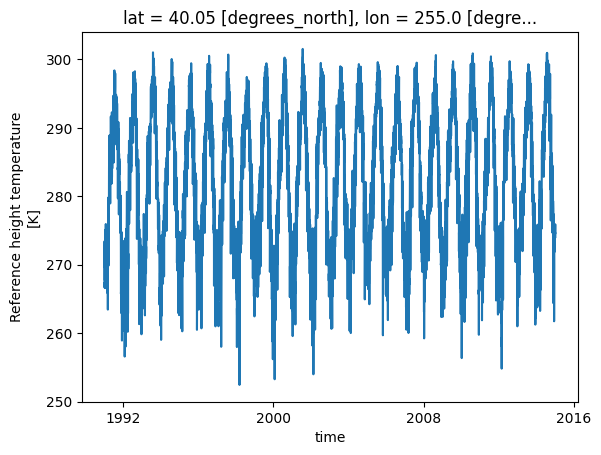

In [16]:
%%time
# Plot raw data
historical_cmip6_30years.plot()

In [17]:
# historical_cmip6_30years.values

In [18]:
%%time
hist_cmip6_monthly = gc.climatology_average(historical_cmip6_30years,freq='month')
hist_cmip6_monthly

CPU times: user 107 ms, sys: 6.7 ms, total: 114 ms
Wall time: 197 ms


<xarray.DataArray 'TREFHT' (time: 12)> Size: 48B
dask.array<groupby_nanmean, shape=(12,), dtype=float32, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 96B 2002-01-16 12:00:00 ... 2002-12-16 12:00:00
    lat        float64 8B 40.05
    lon        float64 8B 255.0
    member_id  <U12 48B 'r10i1181p1f1'
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

CPU times: user 125 ms, sys: 11.2 ms, total: 137 ms
Wall time: 3.6 s


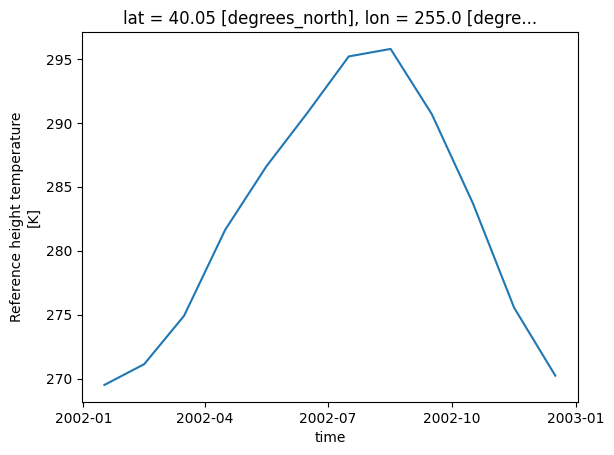

In [19]:
%%time
hist_cmip6_monthly.plot()

In [20]:
cluster.close()

<!-- cluster.close() -->